## Reliability-Based Multi-Objective Optimization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.rnsga3 import RNSGA3
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

In [2]:
# Define the multi-objective optimization problem
class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(
            n_var=2,
            n_obj=2,
            n_constr=1,
            xl=np.array([0.0, 0.0]),
            xu=np.array([1.0, 1.0])
        )

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[0]**2 + x[1]**2
        f2 = (x[0] - 1)**2 + (x[1] - 1)**2
        g1 = x[0]**2 + x[1]**2 - 1
        out["F"] = [f1, f2]
        out["G"] = [g1]
# Initialize the problem
problem = MyProblem()

In [3]:
# Define the algorithm to use
algorithm = NSGA2(pop_size=200)

# Perform the optimization
res = minimize(
    problem,
    algorithm,
    ('n_gen', 100),
    seed=1,
    verbose=True
)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      200 |     43 |  0.000000E+00 |  0.0729495038 |             - |             -
     2 |      400 |     71 |  0.000000E+00 |  0.000000E+00 |  0.0105367946 |         nadir
     3 |      600 |     97 |  0.000000E+00 |  0.000000E+00 |  0.0044509413 |             f
     4 |      800 |    141 |  0.000000E+00 |  0.000000E+00 |  0.0060783160 |         nadir
     5 |     1000 |    188 |  0.000000E+00 |  0.000000E+00 |  0.0067133431 |         ideal
     6 |     1200 |    200 |  0.000000E+00 |  0.000000E+00 |  0.0031151676 |         ideal
     7 |     1400 |    200 |  0.000000E+00 |  0.000000E+00 |  0.0012370324 |             f
     8 |     1600 |    200 |  0.000000E+00 |  0.000000E+00 |  0.0020022934 |             f
     9 |     1800 |    200 |  0.000000E+00 |  0.000000E+00 |  0.0031045526 |         ideal
    10 |     2000 |    200 |  0.000000E+00 |  0.000000E+00 |  0.0007481379 |             f

    90 |    18000 |    200 |  0.000000E+00 |  0.000000E+00 |  0.0023227367 |             f
    91 |    18200 |    200 |  0.000000E+00 |  0.000000E+00 |  0.0024316293 |             f
    92 |    18400 |    200 |  0.000000E+00 |  0.000000E+00 |  0.0024748784 |             f
    93 |    18600 |    200 |  0.000000E+00 |  0.000000E+00 |  0.0025176423 |             f
    94 |    18800 |    200 |  0.000000E+00 |  0.000000E+00 |  0.0006449580 |             f
    95 |    19000 |    200 |  0.000000E+00 |  0.000000E+00 |  0.0010154959 |             f
    96 |    19200 |    200 |  0.000000E+00 |  0.000000E+00 |  0.0012540947 |             f
    97 |    19400 |    200 |  0.000000E+00 |  0.000000E+00 |  0.0014975204 |             f
    98 |    19600 |    200 |  0.000000E+00 |  0.000000E+00 |  0.0016050158 |             f
    99 |    19800 |    200 |  0.000000E+00 |  0.000000E+00 |  0.0017317382 |             f
   100 |    20000 |    200 |  0.000000E+00 |  0.000000E+00 |  0.0019484951 |             f

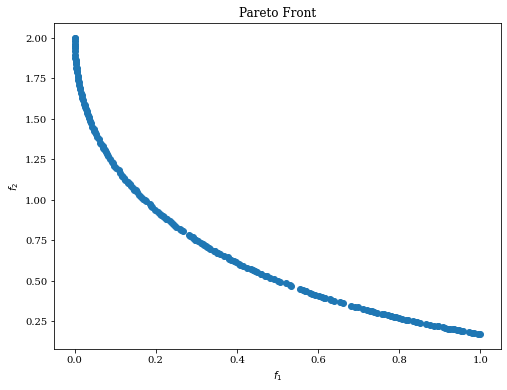

In [4]:
# Extract the Pareto front
pareto_front = res.F
pareto_solutions = res.X
# Visualize the Pareto front
plot = Scatter(title="Pareto Front")
plot.add(pareto_front)
plot.show()

In [5]:
beta_t = 3
        
def limit_state_function(x):
    return -(x[0]**2 + x[1]**2 - 1)

def gradient_limit_state_function(x):
    return -np.array([2*x[0], 2*x[1]])

def transform_to_u(x,mu):
    return (x - mu)/0.2

def transform_to_x(u,mu):
    return 0.2* u + mu

def amv_method(x,beta_t, max_iter=100, tol=1e-6):
    u_amv = np.zeros(2)
    for k in range(max_iter):
        x_amv = transform_to_x(u_amv,x)
        grad_g = gradient_limit_state_function(x_amv)
        norm_grad_g = np.linalg.norm(grad_g)
        n_u_amv = -grad_g / norm_grad_g
        u_amv_next = beta_t * n_u_amv
        if np.linalg.norm(u_amv_next - u_amv) < tol:
            break
        u_amv = u_amv_next
#                 print(u_amv)
#         print(np.linalg.norm(u_amv))
    return u_amv        


In [6]:
def compute_theta(u_acc, u_acc_next):
    # Compute the angle (theta) between vectors u_acc and u_acc_next
    dot_product = np.dot(u_acc, u_acc_next)
    norms_product = np.linalg.norm(u_acc) * np.linalg.norm(u_acc_next)
    cos_theta = dot_product / norms_product
    theta = np.arccos(np.clip(cos_theta, -1.0, 1.0))
    return theta

def hmv_method(x,beta_t, max_iter=100, tol=1e-6):
    u_acc = np.zeros(2)  # Initialize u_ACC
    lam_acc = 1.0  # Initial value of lambda_ACC
    C = np.eye(2)  # Identity matrix as the involutory matrix

    for k in range(max_iter):
        x_acc = transform_to_x(u_acc,x)
        grad_g = gradient_limit_state_function(x_acc)
        norm_grad_g = np.linalg.norm(grad_g)
        n_hat = -grad_g / norm_grad_g  # n_hat(u_ACC)

        # Update u_ACC
        u_acc_next = beta_t * n_hat

        # Compute theta values
        theta_k_ACC = compute_theta(u_acc, u_acc_next)
        theta_k_minus1_ACC = theta_k_ACC  # Since it's based on the current and next step

        # Update lambda_ACC based on the adaptive rule from the image
        if theta_k_ACC > theta_k_minus1_ACC * 0.2:
            lam_acc = 0.2 * lam_acc
        elif theta_k_ACC <= theta_k_minus1_ACC:
            if theta_k_ACC > 0.2 * theta_k_minus1_ACC:
                lam_acc = lam_acc * theta_k_minus1_ACC / theta_k_ACC
            else:
                lam_acc = lam_acc

        # Check for convergence
        if np.linalg.norm(u_acc_next - u_acc) < tol:
            break

        u_acc = u_acc_next

    return u_acc

## For $\beta$ = 2.0

In [7]:
# Define the multi-objective optimization problem
class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(
            n_var=2,
            n_obj=2,
            n_constr=1,
            xl=np.array([0.0, 0.0]),
            xu=np.array([1.0, 1.0])
        )

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[0]**2 + x[1]**2
        f2 = (x[0] - 1)**2 + (x[1] - 1)**2
#         mptp = amv_method(x,beta_t)
        beta_t = 2.0
        mptp = hmv_method(x,beta_t)
        xt = transform_to_x(mptp,x)  
        g1 = xt[0]**2 + xt[1]**2 - 1
        out["F"] = [f1, f2]
        out["G"] = [g1]

# Initialize the problem
problemR1 = MyProblem()

In [8]:
# Define the algorithm to use
algorithm = NSGA2(pop_size=100)

# Perform the optimization
resR1 = minimize(
    problemR1,
    algorithm,
    ('n_gen', 100),
    seed=10,
    verbose=True
)

<ipython-input-6-7715f9c54140>:5: RuntimeWarning: invalid value encountered in scalar divide
  cos_theta = dot_product / norms_product


n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |     13 |  0.000000E+00 |  0.4465533520 |             - |             -
     2 |      200 |     26 |  0.000000E+00 |  0.0045662871 |  0.0672183964 |         ideal
     3 |      300 |     41 |  0.000000E+00 |  0.000000E+00 |  0.0233519138 |         ideal
     4 |      400 |     72 |  0.000000E+00 |  0.000000E+00 |  0.0170277095 |         ideal
     5 |      500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0122518375 |         nadir
     6 |      600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0047243426 |         nadir
     7 |      700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0023198368 |             f
     8 |      800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0052461670 |         ideal
     9 |      900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0016637035 |             f
    10 |     1000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0042268207 |         nadir

    92 |     9200 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0023105471 |             f
    93 |     9300 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0032010236 |             f
    94 |     9400 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0014801017 |             f
    95 |     9500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0026618429 |             f
    96 |     9600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0014733662 |             f
    97 |     9700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0024875232 |             f
    98 |     9800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0034200468 |             f
    99 |     9900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0017517501 |             f
   100 |    10000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0023926057 |             f


## For $\beta$ = 3.0

In [9]:
# Define the multi-objective optimization problem
class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(
            n_var=2,
            n_obj=2,
            n_constr=1,
            xl=np.array([0.0, 0.0]),
            xu=np.array([1.0, 1.0])
        )

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[0]**2 + x[1]**2
        f2 = (x[0] - 1)**2 + (x[1] - 1)**2
#         mptp = amv_method(x,beta_t)
        beta_t = 3.0
        mptp = hmv_method(x,beta_t)
        xt = transform_to_x(mptp,x)  
        g1 = xt[0]**2 + xt[1]**2 - 1
        out["F"] = [f1, f2]
        out["G"] = [g1]

# Initialize the problem
problemR2 = MyProblem()

In [10]:
# Define the algorithm to use
algorithm = NSGA2(pop_size=100)

# Perform the optimization
resR2 = minimize(
    problemR2,
    algorithm,
    ('n_gen', 100),
    seed=10,
    verbose=True
)

<ipython-input-6-7715f9c54140>:5: RuntimeWarning: invalid value encountered in scalar divide
  cos_theta = dot_product / norms_product


n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      8 |  0.000000E+00 |  0.8547006169 |             - |             -
     2 |      200 |     18 |  0.000000E+00 |  0.1458680097 |  0.1243272996 |         ideal
     3 |      300 |     34 |  0.000000E+00 |  0.000000E+00 |  0.0754947964 |         ideal
     4 |      400 |     48 |  0.000000E+00 |  0.000000E+00 |  0.0093954827 |         ideal
     5 |      500 |     71 |  0.000000E+00 |  0.000000E+00 |  0.0252820332 |         nadir
     6 |      600 |     91 |  0.000000E+00 |  0.000000E+00 |  0.0038711367 |             f
     7 |      700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0053885322 |         nadir
     8 |      800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0088305254 |         ideal
     9 |      900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0020488419 |             f
    10 |     1000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0032600506 |             f

    90 |     9000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0020144840 |             f
    91 |     9100 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0028943066 |             f
    92 |     9200 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0016468923 |             f
    93 |     9300 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0027101619 |             f
    94 |     9400 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0010467323 |             f
    95 |     9500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0019406048 |             f
    96 |     9600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0031934529 |             f
    97 |     9700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0014184732 |             f
    98 |     9800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0022708868 |             f
    99 |     9900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0029334905 |             f
   100 |    10000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0016660062 |             f

## For $\beta$ = 4.0

In [11]:
# Define the multi-objective optimization problem
class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(
            n_var=2,
            n_obj=2,
            n_constr=1,
            xl=np.array([0.0, 0.0]),
            xu=np.array([1.0, 1.0])
        )

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[0]**2 + x[1]**2
        f2 = (x[0] - 1)**2 + (x[1] - 1)**2
#         mptp = amv_method(x,beta_t)
        beta_t = 4.0
        mptp = hmv_method(x,beta_t)
        xt = transform_to_x(mptp,x)  
        g1 = xt[0]**2 + xt[1]**2 - 1
        out["F"] = [f1, f2]
        out["G"] = [g1]

# Initialize the problem
problemR3 = MyProblem()

In [12]:
# Define the algorithm to use
algorithm = NSGA2(pop_size=100)

# Perform the optimization
resR3 = minimize(
    problemR3,
    algorithm,
    ('n_gen', 100),
    seed=10,
    verbose=True
)

<ipython-input-6-7715f9c54140>:5: RuntimeWarning: invalid value encountered in scalar divide
  cos_theta = dot_product / norms_product


n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      2 |  0.000000E+00 |  1.3948335184 |             - |             -
     2 |      200 |      5 |  0.000000E+00 |  0.4810041202 |  0.7476184781 |         ideal
     3 |      300 |     14 |  0.000000E+00 |  0.1462673736 |  0.1827589613 |         ideal
     4 |      400 |     33 |  0.000000E+00 |  0.0139097818 |  0.0364161050 |         ideal
     5 |      500 |     52 |  0.000000E+00 |  0.000000E+00 |  0.0398381306 |         ideal
     6 |      600 |     69 |  0.000000E+00 |  0.000000E+00 |  0.0052866735 |             f
     7 |      700 |     99 |  0.000000E+00 |  0.000000E+00 |  0.0158209755 |         ideal
     8 |      800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0022465479 |             f
     9 |      900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0041678524 |         nadir
    10 |     1000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0025507485 |         ideal

    93 |     9300 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0014439935 |             f
    94 |     9400 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0021090382 |             f
    95 |     9500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0028162309 |             f
    96 |     9600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0014724845 |             f
    97 |     9700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0023006208 |             f
    98 |     9800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0030067925 |             f
    99 |     9900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0010642777 |             f
   100 |    10000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0017057601 |             f


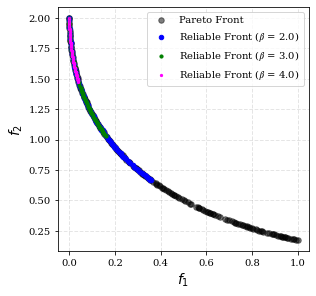

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4.5, 4.5))
plt.scatter(res.F[:, 0], res.F[:, 1], s=30, label='Pareto Front', color='black', alpha=0.5)
plt.scatter(resR1.F[:, 0], resR1.F[:, 1], s=20, label='Reliable Front ($𝛽$ = 2.0)', color='blue', alpha=1.0)
plt.scatter(resR2.F[:, 0], resR2.F[:, 1], s=10, label='Reliable Front ($𝛽$ = 3.0)', color='green', alpha=1.0)
plt.scatter(resR3.F[:, 0], resR3.F[:, 1], s=5, label='Reliable Front ($𝛽$ = 4.0)', color='magenta', alpha=1.0)
plt.xlabel('$f_1$',fontsize=14)
plt.ylabel('$f_2$',fontsize=14)
# plt.title('Pareto Front and Reliable Front',fontsize=15)
plt.legend()
plt.grid(color='k', linestyle='--', linewidth=1, alpha=0.1)
# plt.savefig("Bench1_RF.pdf", format="pdf", bbox_inches="tight")
plt.show()


## Variation of Constraints with $\beta$ values

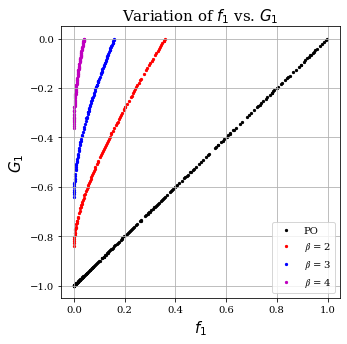

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.scatter(res.F[:, 0], res.G[:, 0], s=5, label='PO', color='black', alpha=1)
plt.scatter(resR1.F[:, 0], resR1.G[:, 0], s=5, label='$𝛽$ = 2', color='r', alpha=1)
plt.scatter(resR2.F[:, 0], resR2.G[:, 0], s=5, label='$𝛽$ = 3', color='b', alpha=1)
plt.scatter(resR3.F[:, 0], resR3.G[:, 0], s=5, label='$𝛽$ = 4', color='m', alpha=1)


plt.xlabel('$f_1$',fontsize=15)
plt.ylabel('$G_1$',fontsize=15)
plt.title('Variation of $f_1$ vs. $G_1$',fontsize=15)
plt.legend()
plt.grid(True)
plt.show()

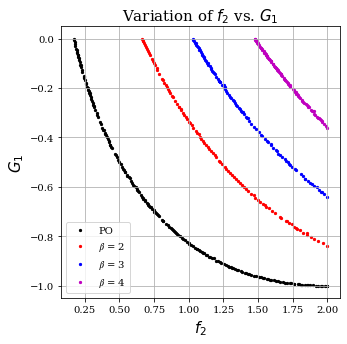

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.scatter(res.F[:, 1], res.G[:, 0], s=5, label='PO', color='black', alpha=1)
plt.scatter(resR1.F[:, 1], resR1.G[:, 0], s=5, label='$𝛽$ = 2', color='r', alpha=1)
plt.scatter(resR2.F[:, 1], resR2.G[:, 0], s=5, label='$𝛽$ = 3', color='b', alpha=1)
plt.scatter(resR3.F[:, 1], resR3.G[:, 0], s=5, label='$𝛽$ = 4', color='m', alpha=1)

plt.xlabel('$f_2$',fontsize=15)
plt.ylabel('$G_1$',fontsize=15)
plt.title('Variation of $f_2$ vs. $G_1$',fontsize=15)
plt.legend()
plt.grid(True)
plt.show()

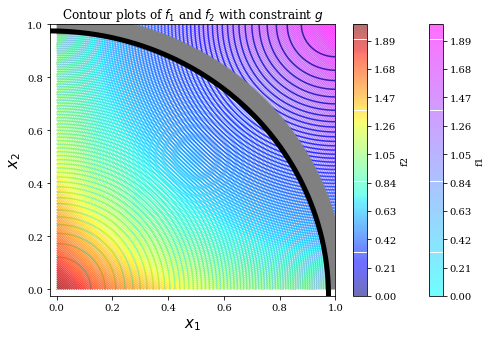

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Define the functions
def f1(x, y):
    return x**2 + y**2

def f2(x, y):
    return (x - 1)**2 + (y - 1)**2

def g1(x, y):
    return x**2 + y**2 - 1

# Create a grid of points
x = np.linspace(0, 1, 400)
y = np.linspace(0, 1, 400)
X, Y = np.meshgrid(x, y)

# Evaluate the functions on the grid
Z1 = f1(X, Y)
Z2 = f2(X, Y)
G1 = g1(X, Y)

# Plot the contour plots
plt.figure(figsize=(8, 5))
cp1 = plt.contour(X, Y, Z1, levels=150, cmap='cool', alpha = 0.75)
cp2 = plt.contour(X, Y, Z2, levels=150, cmap='jet', alpha = 0.75)
plt.contour(X, Y, G1, levels=[0], colors='gray', linewidths=20)  # Constraint
plt.contour(X-0.025, Y-0.025, G1, levels=[0], colors='black', linewidths=5)  # Constraint

# Add colorbars and labels
# plt.clabel(cp1, inline=True, fontsize=8)
# plt.clabel(cp2, inline=True, fontsize=8)
plt.colorbar(cp1, label='f1')
plt.colorbar(cp2, label='f2')
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)
plt.title('Contour plots of $f_1$ and $f_2$ with constraint $g$')

# Show the plot
plt.show()


<ipython-input-17-37f0501d114a>:36: UserWarning: The following kwargs were not used by contour: 'linestyle'
  plt.contour(X, Y, Beta1, levels=[0], colors='m', linestyle='-.-', linewidths=2)  # \beta = 4
<ipython-input-17-37f0501d114a>:37: UserWarning: The following kwargs were not used by contour: 'linestyle'
  plt.contour(X, Y, Beta2, levels=[0], colors='g', linestyle='-.-', linewidths=2)  # \beta = 3
<ipython-input-17-37f0501d114a>:38: UserWarning: The following kwargs were not used by contour: 'linestyle'
  plt.contour(X, Y, Beta3, levels=[0], colors='b', linestyle='-.-', linewidths=2)  # \beta = 2


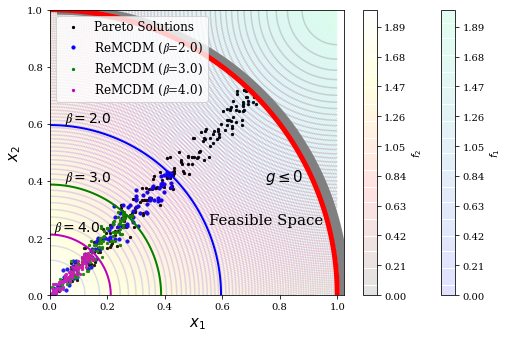

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Define the functions
def f1(x, y):
    return x**2 + y**2

def f2(x, y):
    return (x - 1)**2 + (y - 1)**2

def g1(x, y, A):
    return x**2 + y**2 - A



# Create a grid of points
x = np.linspace(0, 1, 400)
y = np.linspace(0, 1, 400)
X, Y = np.meshgrid(x, y)

# Evaluate the functions on the grid
Z1 = f1(X, Y)
Z2 = f2(X, Y)
G1 = g1(X, Y, 1)
Beta1 = g1(X, Y, 0.045)
Beta2 = g1(X, Y, 0.15)
Beta3 = g1(X, Y, 0.355)

# Plot the contour plots
plt.figure(figsize=(8.25, 5.25))
cp1 = plt.contour(X, Y, Z1, levels=150, cmap='winter', alpha = 0.15)
cp2 = plt.contour(X, Y, Z2, levels=150, cmap='hot', alpha = 0.15)
plt.contour(X+0.025, Y, G1, levels=[0], colors='gray', linewidths=10)  # Constraint
plt.contour(X, Y, G1, levels=[0], colors='r', linewidths=5)  # Constraint

plt.contour(X, Y, Beta1, levels=[0], colors='m', linestyle='-.-', linewidths=2)  # \beta = 4
plt.contour(X, Y, Beta2, levels=[0], colors='g', linestyle='-.-', linewidths=2)  # \beta = 3
plt.contour(X, Y, Beta3, levels=[0], colors='b', linestyle='-.-', linewidths=2)  # \beta = 2

plt.scatter(res.X[:,0]+0.01, res.X[:,1]+0.01, s=5, color='k')
plt.scatter(resR1.X[:,0], resR1.X[:,1], s=10, color='b')
plt.scatter(resR2.X[:,0], resR2.X[:,1], s=5, color='g')
plt.scatter(resR3.X[:,0], resR3.X[:,1], s=5, color='m')
plt.legend(["Pareto Solutions", "ReMCDM ($𝛽$=2.0)","ReMCDM ($𝛽$=3.0)","ReMCDM ($𝛽$=4.0)"], loc ="upper left",fontsize=12)
# Add colorbars and labels
# plt.clabel(cp1, inline=True, fontsize=8)
# plt.clabel(cp2, inline=True, fontsize=8)
plt.text(0.75, 0.4, "$g\leq0$", fontsize=15)
plt.text(0.05, 0.61, "$𝛽=2.0$", fontsize=14)
plt.text(0.05, 0.4, "$𝛽=3.0$", fontsize=14)
plt.text(0.01, 0.225, "$𝛽=4.0$", fontsize=14)
plt.text(0.555, 0.25, "Feasible Space", fontsize=15)
plt.colorbar(cp1, label='$f_1$')
plt.colorbar(cp2, label='$f_2$')
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)
# plt.title('Contour plots of $f_1$ and $f_2$ with constraint $G_1$')
# plt.savefig("Bench1_Sols.pdf", format="pdf", bbox_inches="tight")
# Show the plot
plt.show()


## ReMCDM Using R-NSGA-III

In [18]:
# Define reference points
ref_points = np.array([[0.4, 2.0]])

# Get Algorithm
algorithm = RNSGA3(
    ref_points=ref_points,
    pop_per_ref_point=20,
    mu=0.25)

In [19]:
res_RNS3 = minimize(problemR2,
               algorithm=algorithm,
               termination=('n_gen', 100),
               seed=1,
               verbose=True)

<ipython-input-6-7715f9c54140>:5: RuntimeWarning: invalid value encountered in scalar divide
  cos_theta = dot_product / norms_product
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       22 |      2 |  0.000000E+00 |  0.9563599613 |             - |             -
     2 |       44 |      3 |  0.000000E+00 |  0.1669915937 |  0.0315359642 |         ideal
     3 |       66 |      4 |  0.000000E+00 |  0.000000E+00 |  0.1628178775 |             f
     4 |       88 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0086962259 |         ideal
     5 |      110 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0085532773 |             f
     6 |      132 |      8 |  0.000000E+00 |  0.000000E+00 |  0.0099188196 |         ideal
     7 |      154 |      8 |  0.000000E+00 |  0.000000E+00 |  0.0128848273 |         ideal
     8 |      176 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0059634949 |             f
     9 |      198 |     12 |  0.000000E+00 |  0.000000E+00 |  0.0035306028 |         ideal
    10 |      220 |     14 |  0.000000E+00 |  0.000000E+00 |  0.0107890169 |         nadir

   100 |     2200 |     22 |  0.000000E+00 |  0.000000E+00 |  0.0004961465 |             f


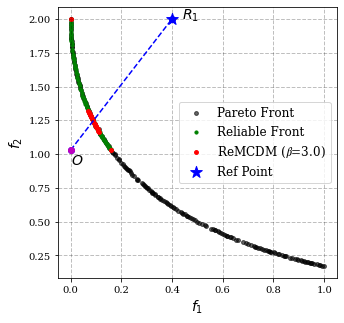

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.scatter(res.F[:, 0], res.F[:, 1], s=15, label='Pareto Front', color='black', alpha=0.6)
plt.scatter(resR2.F[:, 0], resR2.F[:, 1], s=10, label='Reliable Front (RI=3.0)', color='green', alpha=1.0)
plt.scatter(res_RNS3.F[:, 0], res_RNS3.F[:, 1], s=15, label='ReMCDM (RI=4.0)', color='red', alpha=1.0)
plt.scatter(ref_points[:, 0], ref_points[:, 1], s=150,  marker='*', facecolors='b', edgecolors='b')
plt.legend(["Pareto Front", "Reliable Front", "ReMCDM ($𝛽$=3.0)", "Ref Point"], loc ="center right",fontsize=12)

ideal_point = [min(resR2.F[:, 0]), min(resR2.F[:, 1])] 
plt.plot([ideal_point[0], ref_points[0,0]], [ideal_point[1], ref_points[0,1]], 'bo', linestyle="--")
plt.plot([ideal_point[0]], [ideal_point[1]], 'mo', linestyle="--")
plt.text(1.1*ref_points[0,0], 1.0*ref_points[0,1], "$R_1$", fontsize=14)
plt.text(1.02*ideal_point[0],  0.9*ideal_point[1], "$O$", fontsize=14)

plt.xlabel('$f_1$',fontsize=14)
plt.ylabel('$f_2$',fontsize=14)
plt.grid(color='k', linestyle='--', linewidth=1, alpha=0.25)
# plt.savefig("Bench1_ReMCDM.pdf", format="pdf", bbox_inches="tight")